# Notebook 04 : evaluation et metriques
- Ce notebook compare les performances réelles des modèles de segmentation entraînés (UNet Mini et UNet + VGG16), en calculant deux métriques professionnelles : **IoU** et **Dice coefficient**.
### Définitions des métriques :

- **IoU (Intersection over Union)** :
  Mesure le chevauchement entre la prédiction et la vérité terrain.
  
  $\text{IoU} = \frac{Aire(intersection)}{Aire(union)}$
  
  ➤ Plus l'IoU est proche de 1, meilleure est la prédiction.

- **Dice coefficient** :
  Variante du F1-score pour les pixels.

  $\text{Dice} = \frac{2 \cdot Aire(intersection)}{Aire(prédiction) + Aire(vérité)}$
  
  ➤ Légèrement plus indulgent que l'IoU, souvent plus élevé.
# 1 - Imports principaux

In [1]:
import os
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, f1_score
from tensorflow.keras.utils import to_categorical

## 1.1 - Chemins utiles

In [2]:
project_root = Path("..").resolve()
models_dir = project_root / "models"
processed_dir = project_root / "data" / "processed"
src_path = project_root / "src"
outputs_dir = project_root / "outputs"
outputs_dir.mkdir(exist_ok=True, parents=True)  # Sécurité création dossier si absent

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils.utils import plot_history
from model_training.train_unet import train_unet_model
from evaluation.evaluation import evaluate_model, evaluate_loaded_model  # 📦 Fonctions maison (src/evaluation/evaluation.py)

## 1.2 - Chargement des données

In [3]:
val_path = processed_dir / "val.npz"
val = np.load(val_path)
X_val, y_val = val["X"], val["Y"]

# 2 - Evaluation des modèles sauvegardés

In [4]:
model_files = [
    ("unet_mini_cityscapes_256x256.h5", "UNet Mini"),
    ("unet_vgg16_a.h5", "UNet VGG16 A"),
    ("unet_vgg16_b.h5", "UNet VGG16 B"),
    ("unet_vgg16_c.h5", "UNet VGG16 C"),
    ("unet_vgg16_d.h5", "UNet VGG16 D")
]

In [5]:
import json
import pandas as pd

# 🔁 Contrôle global
force_retrain = False
results_cache_path = outputs_dir / "evaluation_results.json"

results = []

# 🧠 Si cache déjà existant et pas de force_retrain → on le charge
if results_cache_path.exists() and not force_retrain:
    print(f"[CACHE] Chargement des résultats d'évaluation depuis : {results_cache_path}")
    with open(results_cache_path, "r") as f:
        results = json.load(f)
else:
    # (Ré)évaluation des modèles
    for filename, name in model_files:
        path = models_dir / filename

        if not path.exists():
            print(f"[WARN] Modèle non trouvé : {filename}")
            continue

        print(f"[INFO] Évaluation en cours pour {name}...")
        result = evaluate_model(path, name, X_val, y_val)

        if result is not None:
            results.append(result)
        else:
            print(f"[SKIP] Résultat invalide pour {name} (NoneType)")

    # 💾 On sauvegarde dans le cache
    with open(results_cache_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"[CACHE] Résultats sauvegardés dans : {results_cache_path}")

print(f"\n✅ Modèles évalués ou chargés : {len(results)}")

[INFO] Évaluation en cours pour UNet Mini...

🔍 Évaluation du modèle : UNet Mini


16/16 [==============================] - 12s 772ms/step
[INFO] Évaluation en cours pour UNet VGG16 A...

🔍 Évaluation du modèle : UNet VGG16 A
16/16 [==============================] - 33s 2s/step
[INFO] Évaluation en cours pour UNet VGG16 B...

🔍 Évaluation du modèle : UNet VGG16 B
16/16 [==============================] - 36s 2s/step
[INFO] Évaluation en cours pour UNet VGG16 C...

🔍 Évaluation du modèle : UNet VGG16 C
16/16 [==============================] - 32s 2s/step
[INFO] Évaluation en cours pour UNet VGG16 D...

🔍 Évaluation du modèle : UNet VGG16 D
16/16 [==============================] - 30s 2s/step
[CACHE] Résultats sauvegardés dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\outputs\evaluation_results.json

✅ Modèles évalués ou chargés : 5


# 3 - Comparatif des résultats


📈 Résultats comparatifs IoU/Dice :
          model       IoU      Dice
3  UNet VGG16 C  0.201707  0.257975
2  UNet VGG16 B  0.193679  0.245077
4  UNet VGG16 D  0.188220  0.236604
1  UNet VGG16 A  0.183104  0.231715
0     UNet Mini  0.121930  0.156203


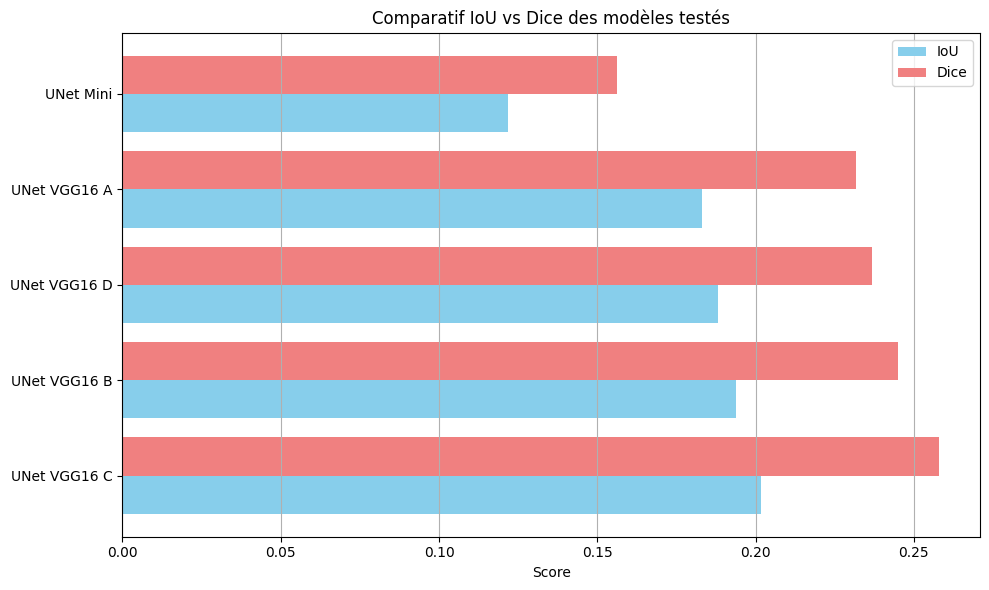

In [6]:
# 🔁 Création du DataFrame avec sécurité
if results:
    try:
        df_results = pd.DataFrame(results).sort_values(by="IoU", ascending=False)
        print("\n📈 Résultats comparatifs IoU/Dice :")
        print(df_results)
    except KeyError as e:
        print(f"\n[ERREUR] Clé manquante dans les résultats : {e}. Vérifiez vos noms de clés dans evaluate_model().")
        df_results = pd.DataFrame()
else:
    print("\n[INFO] Aucun résultat à afficher (results est vide).")
    df_results = pd.DataFrame()

# 📊 Visualisation uniquement si DataFrame valide
if not df_results.empty and {"model", "IoU", "Dice"}.issubset(df_results.columns):
    models = df_results["model"]
    iou_scores = df_results["IoU"]
    dice_scores = df_results["Dice"]

    y = np.arange(len(models))  # positions
    bar_width = 0.4

    plt.figure(figsize=(10, 6))
    plt.barh(y - bar_width/2, iou_scores, height=bar_width, color="skyblue", label="IoU")
    plt.barh(y + bar_width/2, dice_scores, height=bar_width, color="lightcoral", label="Dice")

    plt.yticks(y, models)
    plt.xlabel("Score")
    plt.title("Comparatif IoU vs Dice des modèles testés")
    plt.legend()
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Visualisation annulée : pas de colonnes exploitables dans df_results.")

In [7]:
# Export CSV si df_results exploitable
if not df_results.empty:
    export_path = outputs_dir / "evaluation_results.csv"
    df_results.to_csv(export_path, index=False)
    print(f"[EXPORT] Résultats exportés dans : {export_path}")

[EXPORT] Résultats exportés dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\outputs\evaluation_results.csv


## 3.2 - Barèmes de qualité de segmentation
### 3.2.1 - IoU :
- < 0.4	🚨 Mauvais — modèle inutilisable
- 0.4 – 0.5	⚠️ Médiocre — très approximatif
- 0.5 – 0.6	😐 Passable — utile mais flou
- 0.6 – 0.75	👍 Bon — niveau production acceptable
- 0.75 – 0.85	✅ Très bon — bonne précision globale
- \> 0.85	🏆 Excellent — quasi-expert / médical
### 3.2.2 - Dice Coefficient :
- < 0.5	🚨 Faible — sursegmentation/erreurs
- 0.5 – 0.6	⚠️ Médiocre — limite exploitable
- 0.6 – 0.7	😐 Moyen — correct mais améliorable
- 0.7 – 0.85	👍 Bon — souvent suffisant en pratique
- 0.85 – 0.95	✅ Très bon — production ou santé
- \> 0.95	🏆 Excellent — très proche vérité terrain
# 4 - Sélection du meilleur modèle

In [8]:
if not df_results.empty and "IoU" in df_results.columns:
    best_model = df_results.iloc[0]
    print(f"\n🏆 Modèle champion : {best_model['model']} avec IoU = {best_model['IoU']:.4f}, Dice = {best_model['Dice']:.4f}")
else:
    print("\n[AUCUN MODÈLE VALIDE] Aucun modèle avec métrique IoU trouvée.")


🏆 Modèle champion : UNet VGG16 C avec IoU = 0.2017, Dice = 0.2580


## 4.1 - Visualisation du modèle champion (barplot)

C:\Users\motar\AppData\Local\Temp\ipykernel_4632\4210286671.py:11: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


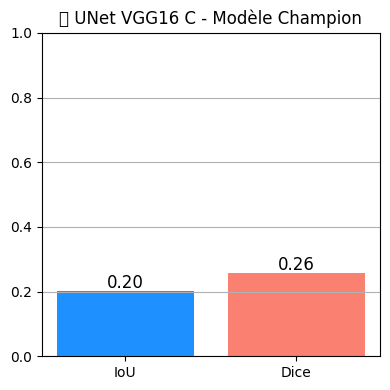

In [9]:
if not df_results.empty and "IoU" in df_results.columns:
    best_model = df_results.iloc[0]
    
    plt.figure(figsize=(4, 4))
    plt.bar(["IoU", "Dice"], [best_model["IoU"], best_model["Dice"]], color=["dodgerblue", "salmon"])
    plt.title(f"🏆 {best_model['model']} - Modèle Champion")
    plt.ylim(0, 1)
    for i, v in enumerate([best_model["IoU"], best_model["Dice"]]):
        plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=12)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# 5 - Optimisation automatique des hyperparamètres - Optuna + MLFlow

In [10]:
import optuna
from hpo.optuna_unet_vgg16 import launch_optuna_study

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5.1 - Lancement de l’étude Optuna - 18h30min

[I 2025-04-14 21:09:44,607] A new study created in memory with name: unet_vgg16_hpo



🚀 Lancement de l’optimisation Optuna (UNet + VGG16)...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...

Epoch 1/40


1000/1000 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8182
Epoch 1: val_loss improved from inf to 0.44422, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 416s 415ms/step - loss: 0.5059 - accuracy: 0.8182 - val_loss: 0.4442 - val_accuracy: 0.8360
Epoch 2/40


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.8270
Epoch 2: val_loss did not improve from 0.44422
1000/1000 [==============================] - 409s 409ms/step - loss: 0.4489 - accuracy: 0.8270 - val_loss: 0.4443 - val_accuracy: 0.8232
Epoch 3/40
1000/1000 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8321
Epoch 3: val_loss improved from 0.44422 to 0.42487, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 409s 409ms/step - loss: 0.4341 - accuracy: 0.8321 - val_loss: 0.4249 - val_accuracy: 0.8339
Epoch 4/40
1000/1000 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8339
Epoch 4: val_loss improved from 0.42487 to 0.42425, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 4

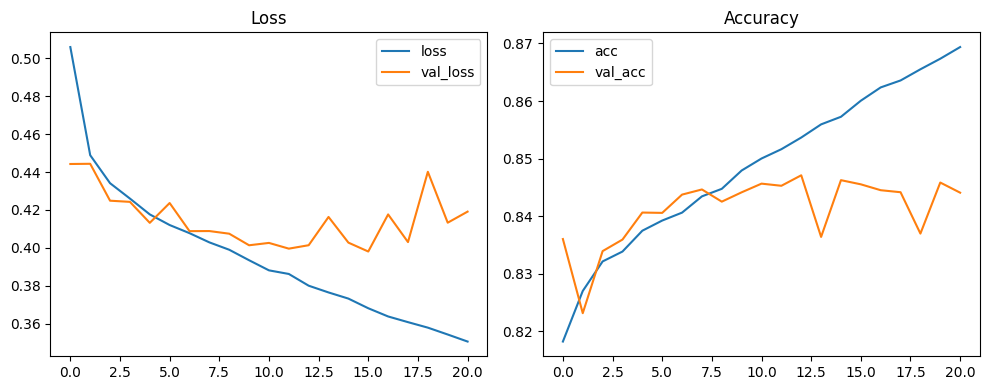

2025/04/14 23:33:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpxsv79oiv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpxsv79oiv\model\data\model\assets
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2025-04-14 23:33:13,705] Trial 0 finished with value: 0.15289366245269775 and parameters: {'batch_size': 4, 'epochs': 40, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 0 with value: 0.15289366245269775.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8182
Epoch 1: val_loss improved from inf to 0.44947, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep20.h5
500/500 [==============================] - 380s 758ms/step - loss: 0.4969 - accuracy: 0.8182 - val_loss: 0.4495 - val_accuracy: 0.8311
Epoch 2/20


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8296
Epoch 2: val_loss improved from 0.44947 to 0.41844, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep20.h5
500/500 [==============================] - 379s 757ms/step - loss: 0.4417 - accuracy: 0.8296 - val_loss: 0.4184 - val_accuracy: 0.8378
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8347
Epoch 3: val_loss improved from 0.41844 to 0.41518, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep20.h5
500/500 [==============================] - 379s 757ms/step - loss: 0.4298 - accuracy: 0.8347 - val_loss: 0.4152 - val_accuracy: 0.8402
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8366
Epoch 4: val_loss improved from 0.41518 to 0.40884, saving model to C:\Users\motar\Desktop\1-openclassr

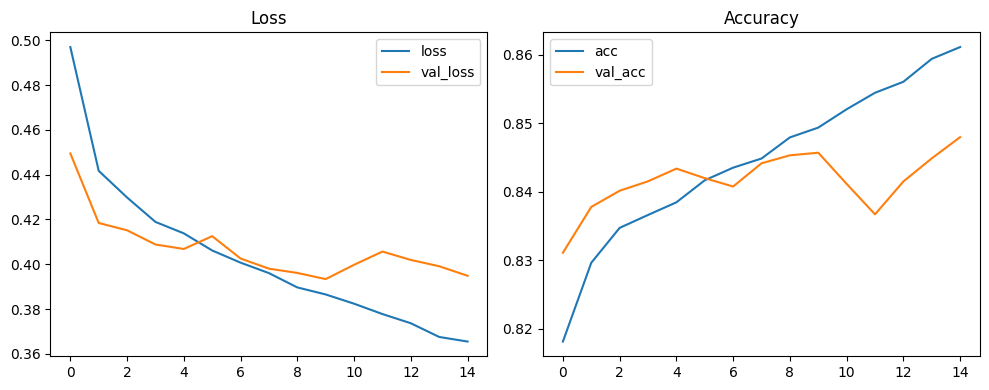

2025/04/15 01:07:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmp0onjp5ho\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmp0onjp5ho\model\data\model\assets
[I 2025-04-15 01:08:04,021] Trial 1 finished with value: 0.15200650691986084 and parameters: {'batch_size': 8, 'epochs': 20, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.8102
Epoch 1: val_loss improved from inf to 0.44172, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep30.h5
250/250 [==============================] - 362s 1s/step - loss: 0.5304 - accuracy: 0.8102 - val_loss: 0.4417 - val_accuracy: 0.8368
Epoch 2/30


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8294
Epoch 2: val_loss improved from 0.44172 to 0.42767, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep30.h5
250/250 [==============================] - 359s 1s/step - loss: 0.4450 - accuracy: 0.8294 - val_loss: 0.4277 - val_accuracy: 0.8345
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8334
Epoch 3: val_loss improved from 0.42767 to 0.41400, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep30.h5
250/250 [==============================] - 361s 1s/step - loss: 0.4290 - accuracy: 0.8334 - val_loss: 0.4140 - val_accuracy: 0.8422
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8364
Epoch 4: val_loss improved from 0.41400 to 0.40859, saving model to C:\Users\motar\Desktop\1-openclassrooms

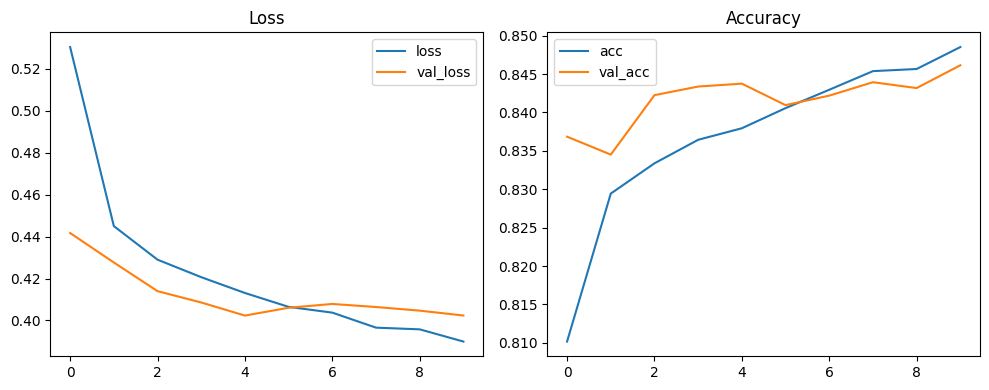

2025/04/15 02:08:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpg6ozz08f\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpg6ozz08f\model\data\model\assets
[I 2025-04-15 02:08:26,065] Trial 2 finished with value: 0.15386539697647095 and parameters: {'batch_size': 16, 'epochs': 30, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.8147
Epoch 1: val_loss improved from inf to 0.48336, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep20.h5
250/250 [==============================] - 362s 1s/step - loss: 0.5304 - accuracy: 0.8147 - val_loss: 0.4834 - val_accuracy: 0.8268
Epoch 2/20


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.8302
Epoch 2: val_loss improved from 0.48336 to 0.44847, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep20.h5
250/250 [==============================] - 361s 1s/step - loss: 0.4433 - accuracy: 0.8302 - val_loss: 0.4485 - val_accuracy: 0.8364
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8336
Epoch 3: val_loss improved from 0.44847 to 0.41270, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs16_ep20.h5
250/250 [==============================] - 362s 1s/step - loss: 0.4292 - accuracy: 0.8336 - val_loss: 0.4127 - val_accuracy: 0.8414
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.4150 - accuracy: 0.8371
Epoch 4: val_loss did not improve from 0.41270
250/250 [==============================] - 360s 1s/step - lo

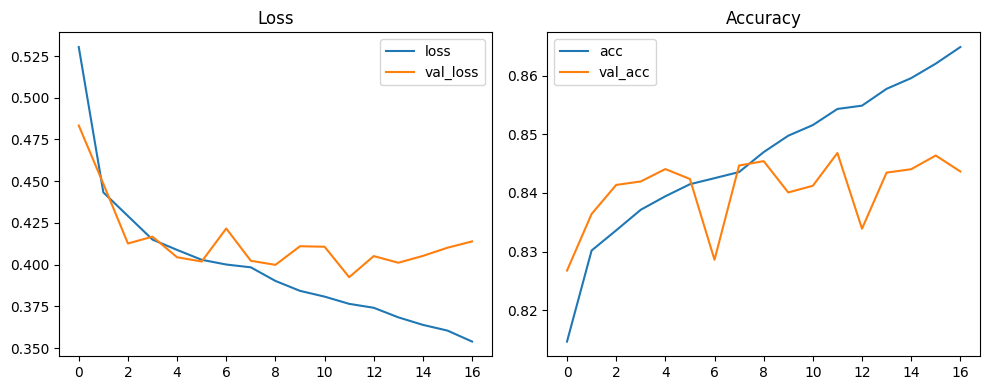

2025/04/15 03:50:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpd60a92hx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpd60a92hx\model\data\model\assets
[I 2025-04-15 03:50:57,749] Trial 3 finished with value: 0.15319031476974487 and parameters: {'batch_size': 16, 'epochs': 20, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/30
1000/1000 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8191
Epoch 1: val_loss improved from inf to 0.48812, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep30.h5
1000/1000 [==============================] - 419s 418ms/step - loss: 0.5162 - accuracy: 0.8191 - val_loss: 0.4881 - val_accuracy: 0.8257
Epoch 2/30


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8309
Epoch 2: val_loss improved from 0.48812 to 0.46315, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep30.h5
1000/1000 [==============================] - 423s 423ms/step - loss: 0.4484 - accuracy: 0.8309 - val_loss: 0.4631 - val_accuracy: 0.8354
Epoch 3/30
1000/1000 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.8343
Epoch 3: val_loss improved from 0.46315 to 0.43095, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep30.h5
1000/1000 [==============================] - 418s 418ms/step - loss: 0.4331 - accuracy: 0.8343 - val_loss: 0.4310 - val_accuracy: 0.8389
Epoch 4/30
1000/1000 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8354
Epoch 4: val_loss improved from 0.43095 to 0.40789, saving model to C:\Users\motar\Desktop\1-

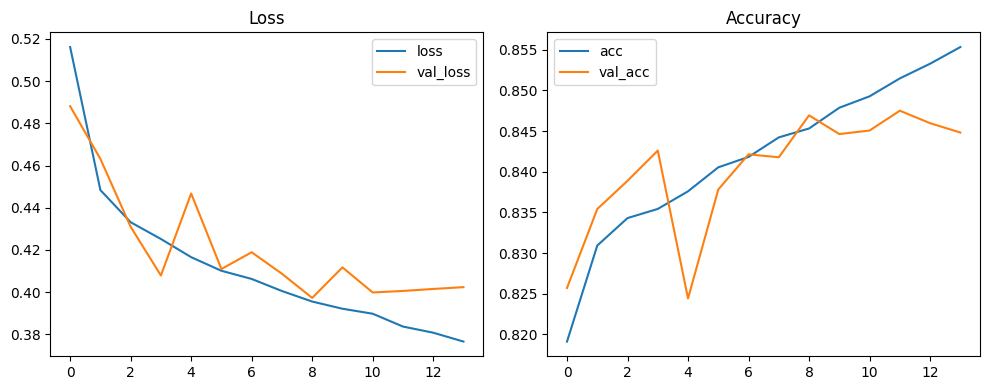

2025/04/15 05:27:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpqco19f1x\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpqco19f1x\model\data\model\assets
[I 2025-04-15 05:27:32,562] Trial 4 finished with value: 0.1524965763092041 and parameters: {'batch_size': 4, 'epochs': 30, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/40
1000/1000 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8186
Epoch 1: val_loss improved from inf to 0.44165, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 409s 408ms/step - loss: 0.4955 - accuracy: 0.8186 - val_loss: 0.4417 - val_accuracy: 0.8330
Epoch 2/40


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8289
Epoch 2: val_loss improved from 0.44165 to 0.43889, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 408s 408ms/step - loss: 0.4444 - accuracy: 0.8289 - val_loss: 0.4389 - val_accuracy: 0.8335
Epoch 3/40
1000/1000 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8329
Epoch 3: val_loss improved from 0.43889 to 0.42018, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep40.h5
1000/1000 [==============================] - 408s 408ms/step - loss: 0.4343 - accuracy: 0.8329 - val_loss: 0.4202 - val_accuracy: 0.8402
Epoch 4/40
1000/1000 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8349
Epoch 4: val_loss did not improve from 0.42018
1000/1000 [==============================] - 4

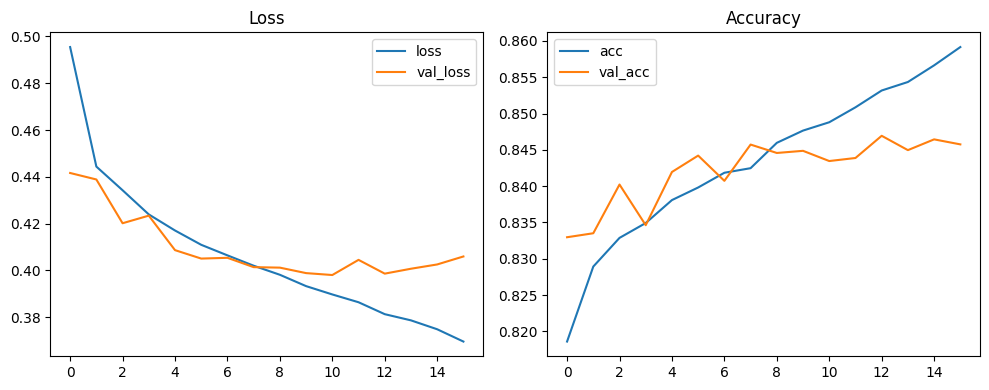

2025/04/15 07:16:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpxj031mig\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpxj031mig\model\data\model\assets
[I 2025-04-15 07:16:52,574] Trial 5 finished with value: 0.15306895971298218 and parameters: {'batch_size': 4, 'epochs': 40, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.8182
Epoch 1: val_loss improved from inf to 0.43342, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 387s 771ms/step - loss: 0.4976 - accuracy: 0.8182 - val_loss: 0.4334 - val_accuracy: 0.8364
Epoch 2/50


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.8292
Epoch 2: val_loss improved from 0.43342 to 0.42873, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 379s 757ms/step - loss: 0.4440 - accuracy: 0.8292 - val_loss: 0.4287 - val_accuracy: 0.8388
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8325
Epoch 3: val_loss did not improve from 0.42873
500/500 [==============================] - 377s 753ms/step - loss: 0.4287 - accuracy: 0.8325 - val_loss: 0.4447 - val_accuracy: 0.8416
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8358
Epoch 4: val_loss improved from 0.42873 to 0.41449, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 377s 755ms/st

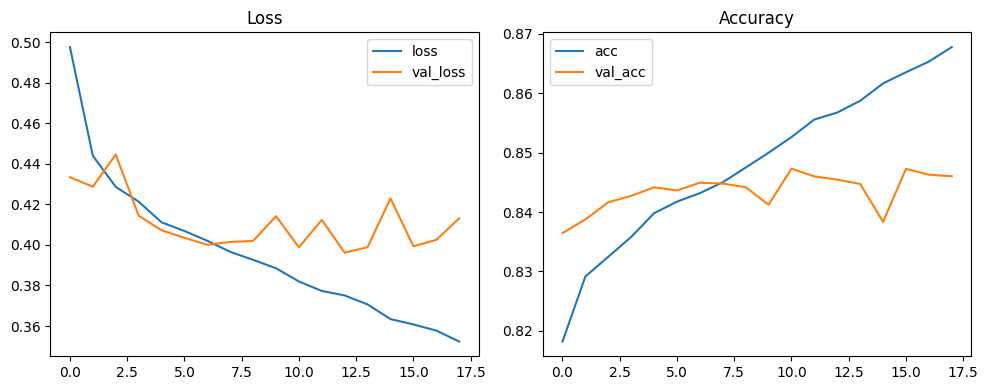

2025/04/15 09:10:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpo3_c27w4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpo3_c27w4\model\data\model\assets
[I 2025-04-15 09:10:52,350] Trial 6 finished with value: 0.152693510055542 and parameters: {'batch_size': 8, 'epochs': 50, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8198
Epoch 1: val_loss improved from inf to 0.44045, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 379s 757ms/step - loss: 0.4969 - accuracy: 0.8198 - val_loss: 0.4405 - val_accuracy: 0.8354
Epoch 2/50


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8291
Epoch 2: val_loss did not improve from 0.44045
500/500 [==============================] - 378s 756ms/step - loss: 0.4406 - accuracy: 0.8291 - val_loss: 0.4420 - val_accuracy: 0.8377
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8326
Epoch 3: val_loss improved from 0.44045 to 0.43255, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 379s 758ms/step - loss: 0.4324 - accuracy: 0.8326 - val_loss: 0.4325 - val_accuracy: 0.8346
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8362
Epoch 4: val_loss improved from 0.43255 to 0.41362, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep50.h5
500/500 [==============================] - 378s 756ms/st

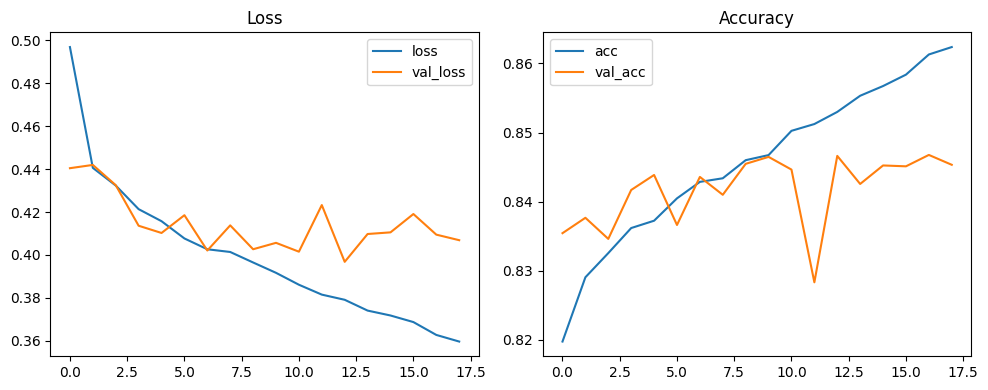

2025/04/15 11:04:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpcwnb654j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpcwnb654j\model\data\model\assets
[I 2025-04-15 11:04:39,805] Trial 7 finished with value: 0.15323621034622192 and parameters: {'batch_size': 8, 'epochs': 50, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8191
Epoch 1: val_loss improved from inf to 0.42700, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep50.h5
1000/1000 [==============================] - 414s 413ms/step - loss: 0.4901 - accuracy: 0.8191 - val_loss: 0.4270 - val_accuracy: 0.8361
Epoch 2/50


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8285
Epoch 2: val_loss improved from 0.42700 to 0.41968, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep50.h5
1000/1000 [==============================] - 410s 410ms/step - loss: 0.4486 - accuracy: 0.8285 - val_loss: 0.4197 - val_accuracy: 0.8360
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8327
Epoch 3: val_loss improved from 0.41968 to 0.41657, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs4_ep50.h5
1000/1000 [==============================] - 410s 410ms/step - loss: 0.4300 - accuracy: 0.8327 - val_loss: 0.4166 - val_accuracy: 0.8404
Epoch 4/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8359
Epoch 4: val_loss improved from 0.41657 to 0.40974, saving model to C:\Users\motar\Desktop\1-

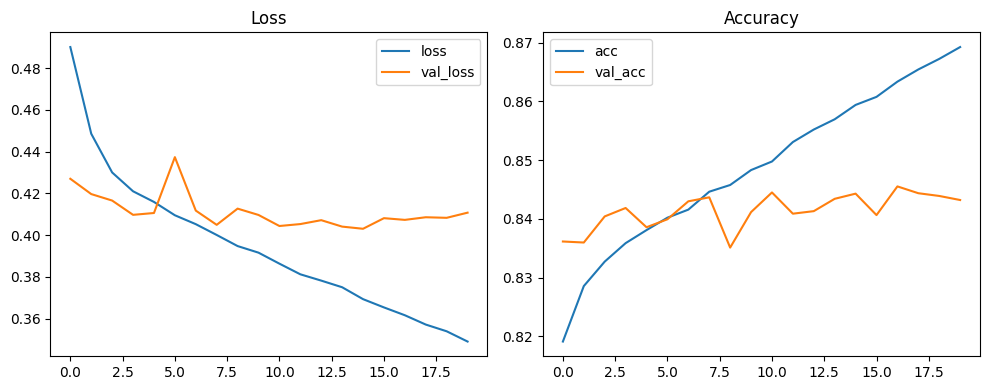

2025/04/15 13:21:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpev98jrvu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpev98jrvu\model\data\model\assets
[I 2025-04-15 13:21:51,119] Trial 8 finished with value: 0.15448683500289917 and parameters: {'batch_size': 4, 'epochs': 50, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.


✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_vgg16 appelé
[INFO] Entraînement d'un modèle UNet + VGG16...
Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.8195
Epoch 1: val_loss improved from inf to 0.44119, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep40.h5
500/500 [==============================] - 381s 759ms/step - loss: 0.5061 - accuracy: 0.8195 - val_loss: 0.4412 - val_accuracy: 0.8316
Epoch 2/40


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8288
Epoch 2: val_loss improved from 0.44119 to 0.43018, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep40.h5
500/500 [==============================] - 379s 758ms/step - loss: 0.4455 - accuracy: 0.8288 - val_loss: 0.4302 - val_accuracy: 0.8341
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8336
Epoch 3: val_loss improved from 0.43018 to 0.42355, saving model to C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_bs8_ep40.h5
500/500 [==============================] - 378s 757ms/step - loss: 0.4321 - accuracy: 0.8336 - val_loss: 0.4235 - val_accuracy: 0.8316
Epoch 4/40
500/500 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8370
Epoch 4: val_loss improved from 0.42355 to 0.41722, saving model to C:\Users\motar\Desktop\1-openclassr

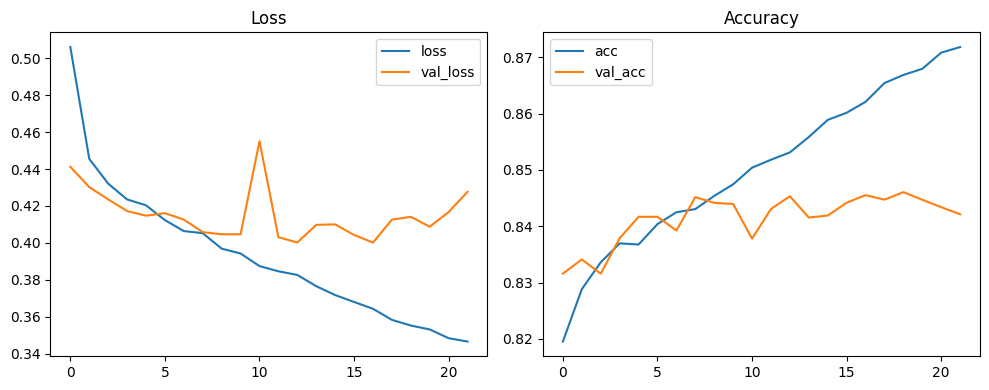

2025/04/15 15:40:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpn5f1lfjm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmpn5f1lfjm\model\data\model\assets
[I 2025-04-15 15:41:03,985] Trial 9 finished with value: 0.1539488434791565 and parameters: {'batch_size': 8, 'epochs': 40, 'loss_function': 'sparse_categorical_crossentropy'}. Best is trial 1 with value: 0.15200650691986084.



🏆 Meilleurs hyperparamètres :
{'batch_size': 8, 'epochs': 20, 'loss_function': 'sparse_categorical_crossentropy'}

💾 Étude sauvegardée dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\models\optuna_vgg16_study.pkl


In [11]:
print("\n🚀 Lancement de l’optimisation Optuna (UNet + VGG16)...")
study = launch_optuna_study(n_trials=10)

## 5.2 - Visualisation des résultats de l’étude Optuna

In [12]:
import matplotlib.pyplot as plt
import optuna.visualization as vis

## 5.3 - Graphique des valeurs d'objectif

C:\Users\motar\AppData\Local\Temp\ipykernel_4632\513309485.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)


[INFO] Visualisation matplotlib indisponible : 'Axes' object has no attribute 'suptitle'


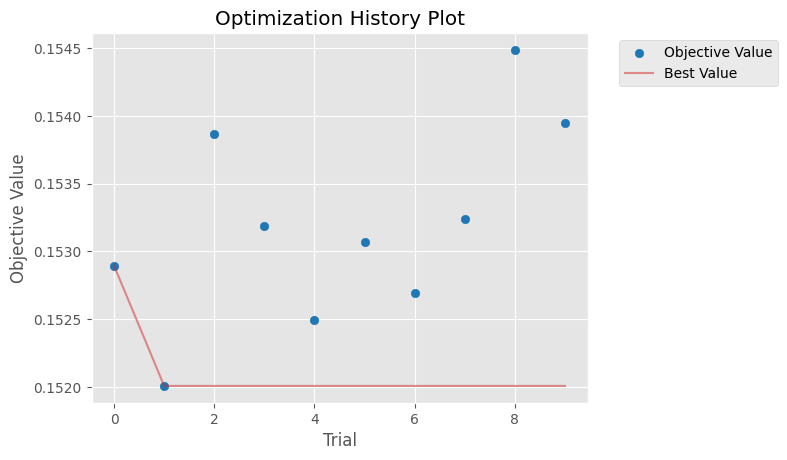

In [13]:
try:
    fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
    fig1.suptitle("Historique d'optimisation (1 - val_accuracy)")
    fig1.show()
except Exception as e:
    print("[INFO] Visualisation matplotlib indisponible :", e)

## 5.4 - Graphe en barres des meilleurs hyperparamètres

In [14]:
best_params = study.best_trial.params
print("\n🏆 Meilleurs hyperparamètres trouvés :")
for k, v in best_params.items():
    print(f"  - {k} : {v}")


🏆 Meilleurs hyperparamètres trouvés :
  - batch_size : 8
  - epochs : 20
  - loss_function : sparse_categorical_crossentropy


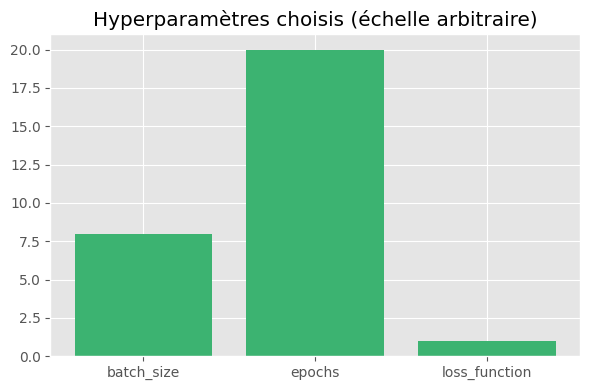

In [15]:
plt.figure(figsize=(6, 4))
plt.bar(best_params.keys(), [float(v) if isinstance(v, (int, float)) else 1 for v in best_params.values()], color="mediumseagreen")
plt.title("Hyperparamètres choisis (échelle arbitraire)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

## 5.5 - Affichage de la meilleure valeur d’objectif atteinte

In [16]:
print(f"\n🔬 Meilleur score (1 - val_accuracy) : {study.best_trial.value:.4f} → val_accuracy ≈ {1 - study.best_trial.value:.4f}")


🔬 Meilleur score (1 - val_accuracy) : 0.1520 → val_accuracy ≈ 0.8480
